In [1]:
import json

with open('C:/Users/sofia/Desktop/Courses/DATA320/My-secrets.json') as f:
    data = json.load(f)

secret_key = data['mongodb']

print(f"My secret key is {len(secret_key)} characters in length.")
    

My secret key is 74 characters in length.


In [3]:
import pymongo
import certifi

client = pymongo.MongoClient(secret_key, tlsCAFile=certifi.where())
print(f"Using MongoDB version {client.server_info()['version']}.")

my_database = client['DATA320']

print(f"This MongoDB server has the databases {my_database}")

all_collections = my_database.list_collection_names()

print(f"This database has the collections{all_collections}")

Using MongoDB version 8.0.9.
This MongoDB server has the databases Database(MongoClient(host=['ac-racepes-shard-00-02.o5q3fj2.mongodb.net:27017', 'ac-racepes-shard-00-00.o5q3fj2.mongodb.net:27017', 'ac-racepes-shard-00-01.o5q3fj2.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-g9enq9-shard-0', tls=True, tlscafile='c:\\Users\\sofia\\anaconda3\\lib\\site-packages\\certifi\\cacert.pem'), 'DATA320')
This database has the collections['IMBD_fixed', 'IMBD', 'Metacritic', 'release_date_pipeline', 'IMBD_pipeline_view', 'release_date', 'IMBD_Pipeline_View', 'IMDB_Pipeline_View_Final']


In [ ]:
# It was so interesting to see how cleverly this is done


from numbers import Number 

def format_currency(amount: Number, _):
    if amount > 1_000_000_000_000:
        return f"${round(amount / 1_000_000_000_000)}T"
    elif amount > 1_000_000_000:
        return f"${round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"${round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"${round(amount / 1_000)}K"
    else:
        return f"${round(amount)}K"

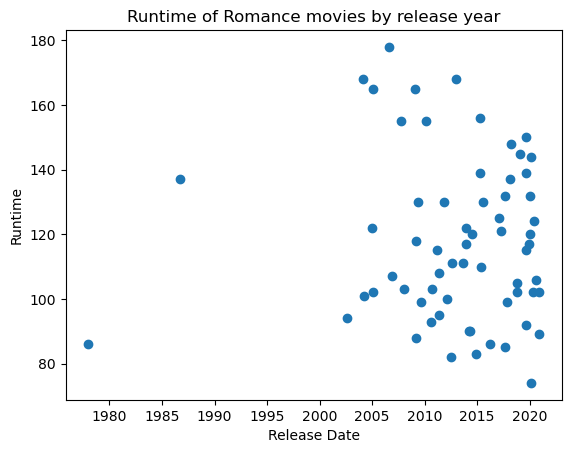

In [ ]:
# First plot seen in class

from matplotlib import pyplot
import pandas 

cursor = my_database["IMDB_Pipeline_View_Final"].find({"genres":{"$in":["Romance"]}})
romance_films = pandas.DataFrame(cursor)

pyplot.title('Runtime of Romance movies by release year')
pyplot.scatter(romance_films['release_date'], romance_films['runtime'])
pyplot.xlabel('Release Date')
pyplot.ylabel('Runtime')
pyplot.show()

For the first plot I wanted to see the comparison of how much budget a movie used and what where its gross sales, 
I wanted to see if movies with bigger budgets tend to earn more, but it’s not always the case. 
Most movies had budgets under $50 million, and they made different amounts, some did well and some didn't. 
Only a few high-budget movies went over $1000M in sales. The plot also shows that just spending a lot doesn’t
mean it will win a lot of money. I was curios about that outlier that costed $300M and earned less than $500M,
and I found that it was "Solo: A Star Wars Story", only to find that this movie was the only one of Disney's five Star Wars movies that lost money in its theatrical run.

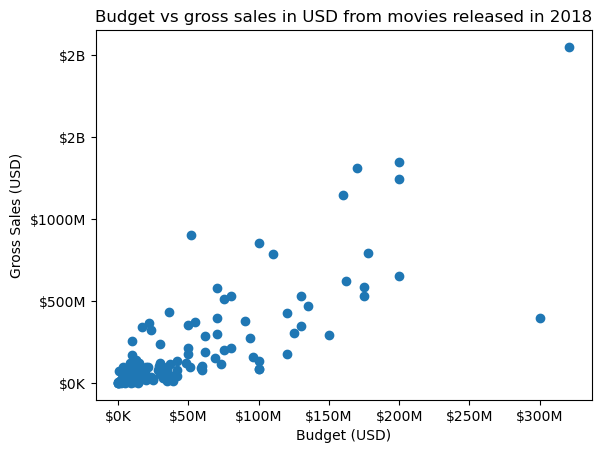

In [33]:
from matplotlib.ticker import FuncFormatter

currency_formatter = FuncFormatter(format_currency)


db = my_database["IMDB_Pipeline_View_Final"].find({"release_year": 2018})
films_2018 = pandas.DataFrame(db)


pyplot.title('Budget vs gross sales in USD from movies released in 2018')
pyplot.scatter(films_2018['budget_usd'], films_2018['gross_sales_usd'])
pyplot.gca().xaxis.set_major_formatter(currency_formatter)
pyplot.gca().yaxis.set_major_formatter(currency_formatter)
pyplot.xlabel('Budget (USD)')
pyplot.ylabel('Gross Sales (USD)')
pyplot.show()

Now, for the second plot I wanted to check which type of rating has the highest average budget, only to find that PG and PG-13 double the average budget than R. From the chart, we can see that PG-13 movies had the highest average budget, above $60 million. PG-rated was close to PG-13, while R-rated is around $20 million. This might be because PG and PG-13 films usually target larger audiences, including families and teens, so studios may be willing to invest more. In contrast, R-rated movies are for adults only, which can limit ticket sales, so producers might spend less on them. I never thought about it, but it was definitely surprising.

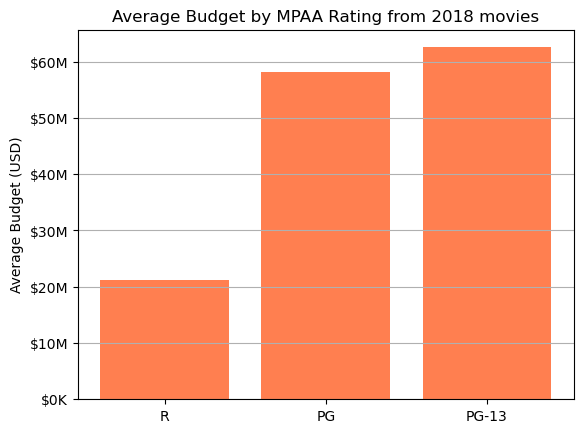

In [49]:
grouped = films_2018.dropna(subset=["budget_usd", "mpaa_rating"])
avg_budgets = grouped.groupby("mpaa_rating")["budget_usd"].mean().sort_values()

pyplot.bar(avg_budgets.index, avg_budgets.values, color="coral")
pyplot.title("Average Budget by MPAA Rating from 2018 movies")
pyplot.ylabel("Average Budget (USD)")
pyplot.gca().yaxis.set_major_formatter(currency_formatter)
pyplot.grid(True, axis='y')
pyplot.show()

For the next one, I wanted to do a plot in time, so I decided to go with gross sales over time in 2018, this plot starts in 0, and grows as more movies are released. It reaches over $30 billion, which is the total revenue the movies industry did in 2018. I think its not that obvious, but you can also spot a few points where sales increased more quickly, these jumps likely come from major releases that earned a lot. The flat parts show weeks where less successful movies came out. Overall, it shows how successful the 2018 movie industry was.

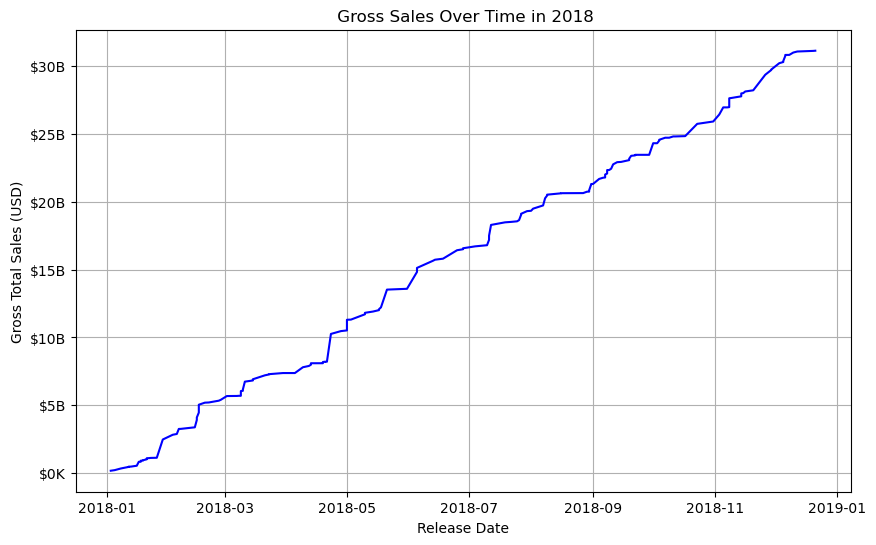

In [52]:
# I wanted to do a timeline, so I investigated on how to do it

timeline = timeline.sort_values("release_date")
timeline["cumulative_gross"] = timeline["gross_sales_usd"].cumsum()

# Plot
pyplot.figure(figsize=(10, 6))
pyplot.plot(timeline["release_date"], timeline["cumulative_gross"], color="blue")
pyplot.title(" Gross Sales Over Time in 2018")
pyplot.xlabel("Release Date")
pyplot.ylabel("Gross Total Sales (USD)")
pyplot.gca().yaxis.set_major_formatter(currency_formatter)
pyplot.grid(True)
pyplot.show()

I wanted to do a heatmat lastly, it shows the average user rating of movies released in 2018, organized by MPAA rating and release month. Each colored box shows how well movies were rated in that category and month, with darker colors representing higher ratings. We can see that PG-rated movies in December got the highest average rating (8.4), while some G-rated movies, like in April (4.2), were rated much lower. PG-13 films stayed pretty consistent across the year, usually around 6.4 to 6.7. R-rated movies were generally in the middle, with scores mostly between 5.4 and 6.4. I was surprised to see that the best movies for PG were released in december like we saw in class! but for G it was in november, still pretty close to the end of the year. 

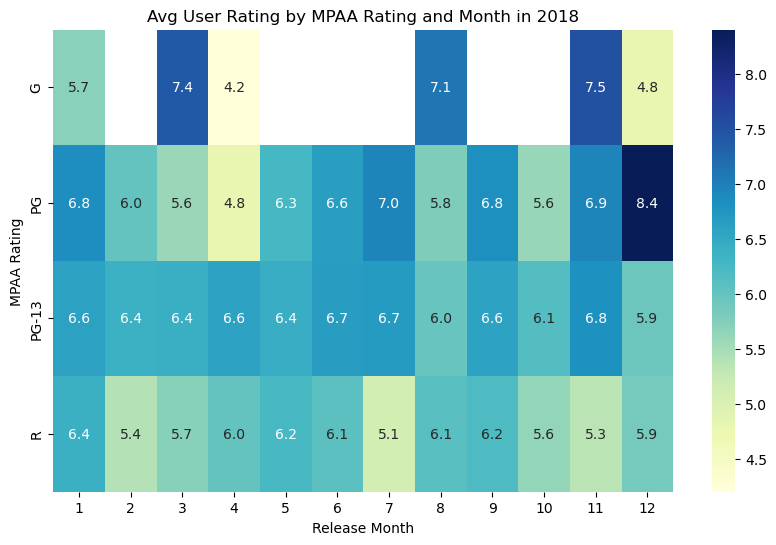

In [56]:
# In my investigation I found that you can do heat maps and I thought it would be so fun to try it out
# In the class it was mentioned that there might be some movies that were better or worse when released in a certain year
#And I also grouped them by MPAA Rating

import seaborn as sns
import pandas as pd

pivot = films_2018.pivot_table(
    index="mpaa_rating",
    columns="release_month",
    values="user_rating",
    aggfunc="mean"
)

pyplot.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".1f")
pyplot.title("Avg User Rating by MPAA Rating and Month in 2018")
pyplot.xlabel("Release Month")
pyplot.ylabel("MPAA Rating")
pyplot.show()